In [1]:
import sys
 # Add end-to-end package to path.
import sys
from pathlib import Path

sys.path.append(str(Path('../src').absolute()))

In [2]:


from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets

# Run the following before any XLA modules such as JAX:
import chex

chex.set_n_cpu_devices(4)


In [3]:

# Import the remaining JAX related 
from gabenet.mcmc import sample_markov_chain
from gabenet.nets import MultinomialDirichletBelieve

import haiku as hk
import jax
from jax import random
import jax.numpy as jnp

2023-05-03 13:52:01.345011: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


To illustrate how to use a [Bayesian Poisson Gamma believe network](https://www.jmlr.org/papers/volume17/15-633/15-633.pdf), we will train the
model on the MNIST dataset, containing handwritten digits.

The dataset can directly be loaded from scikit-learn. As preprocessing step, we reshape the
digits from a 8x8 square matrix to a flat array of size 64.

In [4]:
digits = datasets.load_digits()
n_samples = len(digits.images)
X_train = digits.images.reshape((n_samples, -1))

Next, we define the model. We use a simple decoder networks with two hidden layers. In
total, the size of the network: 2 x 10 x 64.

In [11]:
# Pseudo-random number generator sequence.
key_seq = hk.PRNGSequence(42)

m_samples, n_features = X_train.shape


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:

def build_gamma_belief_net(debug=False):
    """A two-layer decoder network."""
    n_hidden_units = (2, 10)
    return MultinomialDirichletBelieve(n_hidden_units, n_features, gamma_0=3.0, debug=debug)

Since the Poisson gamma believe network is a Bayesian model, we don't train the model by
minimising a loss. Rather, we estimate the distribution of the parameters. To do this,
we make use of Markov chain Monte Carlo simulations. This method samples the distributions by iteratively updating the parameters based on the current state of the model (i.e., the current parameter configuration).
We require two ingredients:
1. A way to propose a new state of the chain.  
  This is called a _kernel_, which takes the
  current state of the chain, and advances it by a single step.


In [6]:
@hk.transform_with_state
def kernel():
    """Advances the Markov chain by one step."""
    model = build_gamma_belief_net()
    model(X_train)

2. A starting point for the chain.  
  For simplicity, we choose to take samples from
  the prior distribution (which is called a forward, or ancestral, sample). 


In [7]:
@hk.transform_with_state
def forward():
    """Initialise Markov chain using forward samples."""
    model = build_gamma_belief_net()
    return model.forward(m_samples)

n_chains = 4
key_per_chain = random.split(next(key_seq), num=n_chains)
param_init, state_init = jax.vmap(forward.init)(key_per_chain)

Finally, we draw samples from the Markov chain. We first take 100 burn-in steps, in the
hope that the chain converges to the true distribution. Thereafter, we collect a total
of 100 samples to estimate the posterior distribution (we don't perform thinning, as
indicated by a leap size of 1).

Note that `sample_markov_chain` (below) automatically takes care of distributing your
computation across multiple devices. For simplicity, we assume you are running on a CPU and split the CPU up in two virtual devices. (See above, at the import section, where we've used
`chex` set the number of devices to 2.)

The following cell, that collects statistics from the Markov chain takes, about `5 minutes` to run on a CPU.

In [8]:
kernel = jax.jit(kernel.apply)

In [7]:
%load_ext tensorboard
from io import BytesIO

import tensorflow as tf
from pathlib import Path

def plot_to_tensor(figure):
    """Convert matplotlib figure to tensor flow image."""
    # Save the plot to a PNG in memory.
    buf = BytesIO()
    plt.savefig(buf, format="png")
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    return tf.expand_dims(image, 0)


In [8]:

TENSORBOARD_LOG = Path("/tmp/headless")
TENSORBOARD_LOG.mkdir(parents=True, exist_ok=True)
writer = tf.summary.create_file_writer(str(TENSORBOARD_LOG))

In [9]:
def plot_convergence_2d(states):
    f = plt.figure()
    for i in range(n_chains):
        plt.plot(states[i, :, 0], states[i, :, 1], '-o', label=f'chain: {i}')
    plt.legend()
    return f

def plot_convergence_1d(states):
    f = plt.figure()
    for i in range(n_chains):
        plt.plot(np.arange(states[i].shape[0]), states[i], label=f'chain {i}')
    plt.legend()
    return f

In [6]:
def plots_to_tensorboard(states, writer, i):
    with writer.as_default():
        r_states = states['multinomial_dirichlet_believe/~/multinomial_cap_layer']['r']
        f_r = plot_convergence_2d(r_states)
        tf.summary.image('r', plot_to_tensor(f_r), step=i)
        
        c = states['multinomial_dirichlet_believe/~/dirichlet_layer']['c']
        f_c = plot_convergence_1d(c)
        tf.summary.image('c', plot_to_tensor(f_c), step=i)
        writer.flush()

In [13]:
states = sample_markov_chain(
    next(key_seq), 
    n_samples=100, 
    kernel_fn=kernel, 
    initial_params=param_init, 
    initial_state=state_init,
    n_burnin_steps=100, 
    # n_leap_size=0,
)
states['multinomial_dirichlet_believe/~/dirichlet_layer']['c'].block_until_ready()

Array([[0.22270776, 0.21741463, 0.21258181, 0.21438594, 0.21864216,
        0.2149665 , 0.21704416, 0.20950218, 0.20838332, 0.2119391 ,
        0.22202343, 0.2241233 , 0.22534448, 0.21954198, 0.22315377,
        0.21245076, 0.21733198, 0.2189596 , 0.20923357, 0.22507526,
        0.22713415, 0.22323966, 0.22777939, 0.22210895, 0.22488473],
       [0.05139878, 0.0514898 , 0.05277447, 0.05177938, 0.05103014,
        0.05291803, 0.05728904, 0.05663906, 0.05265199, 0.05611695,
        0.06439094, 0.05589953, 0.056494  , 0.05687576, 0.05485075,
        0.05248472, 0.05478273, 0.05469201, 0.0586751 , 0.05539551,
        0.05723169, 0.06031337, 0.06278035, 0.05921972, 0.06145917],
       [0.8563619 , 0.82960635, 0.82087076, 0.8186433 , 0.8302041 ,
        0.8172597 , 0.81704473, 0.82141113, 0.81552446, 0.81877774,
        0.8219181 , 0.8204428 , 0.82845694, 0.8304329 , 0.81848776,
        0.8260157 , 0.83539623, 0.82377803, 0.8326896 , 0.8349887 ,
        0.8254279 , 0.81484836, 0.81982833, 0.

In [18]:
last_state = jax.tree_util.tree_map(lambda x: x[0, -1, ...], states)
# last_state = jax.tree_util.tree_map(lambda x: x[0], state_init)

@hk.transform_with_state
def kernel_bk(x_images, is_training: bool = True):
    """Advances the Markov chain by one step."""
    model = build_gamma_belief_net(is_training)
    model(x_images)

kernel_bk.apply(param_init, last_state, next(key_seq), X_train)

> /home/hylke/workspace/gabenet/src/gabenet/multinomial.py(175)upward()
    174                 ipdb.set_trace()
--> 175             c: Array0[float32] = posterior_gamma_chinese_restaurant_table(
    176                 hk.next_rng_key(), m=n_i, n=n_previous, a=self.e_0, b=self.f_0  # type: ignore

> /home/hylke/workspace/gabenet/src/gabenet/multinomial.py(176)upward()
    175             c: Array0[float32] = posterior_gamma_chinese_restaurant_table(
--> 176                 hk.next_rng_key(), m=n_i, n=n_previous, a=self.e_0, b=self.f_0  # type: ignore
    177             )

    171                 # jax.debug.breakout()
    172                 import ipdb
    173 
    174                 ipdb.set_trace()
    175             c: Array0[float32] = posterior_gamma_chinese_restaurant_table(
--> 176                 hk.next_rng_key(), m=n_i, n=n_previous, a=self.e_0, b=self.f_0  # type: ignore
    177             )
    178             self._set("c", c)
    179 
    180         return m_ik, n_

(None,
 {'multinomial_dirichlet_believe/~/dirichlet_layer': {'c': Array(0.22768657, dtype=float32),
   'm': Array([[293,   0,   0, ...,   0,   0,   0],
          [  0,   0,  10, ...,  21,   1,   0],
          [  0,   0,   0, ..., 209,   0,   0],
          ...,
          [374,   0,   0, ...,   0,   0,   0],
          [  0,  48,   0, ...,   0,   0,   0],
          [ 39,   0,   0, ..., 353,   0,   0]], dtype=uint32),
   'phi': Array([[0.20307451, 0.05782793, 0.08179807, 0.01980567, 0.06746607,
           0.01592278, 0.02529381, 0.32547203, 0.14134651, 0.06199255],
          [0.1017964 , 0.0585731 , 0.08571082, 0.16326308, 0.06312074,
           0.02588104, 0.264548  , 0.02547231, 0.06779065, 0.14384384]],      dtype=float32),
   'rate': Array([[[3.44594158e-02, 5.90399001e-03],
           [9.81273688e-03, 3.39712459e-03],
           [1.38801951e-02, 4.97105811e-03],
           ...,
           [5.52288741e-02, 1.47734385e-03],
           [2.39848830e-02, 3.93172400e-03],
           [1.0519

In [30]:
last_state['multinomial_dirichlet_believe/~/dirichlet_layer']['m'][:10]

Array([[289,   0,   0,   0,   0,   0,   4,   0,   1,   0],
       [  0,   0,   2,   0,  30, 169,  82,  30,   0,   0],
       [  0,   0,   0,   0, 123,   0,   0, 221,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 267],
       [  0,   0,   0,  24,   0,   0, 234,   0,   0,   0],
       [  0,   0,   4,   0,   0,   0,   0,   0,   3, 335],
       [282,   0,  24,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0, 289,   0,   0],
       [346,   0,   0,   0,   0,   0,   0,  11,   0,   0],
       [  0,   0,   0,   0,   0,   0, 232,  97,   0,   0]], dtype=uint32)

In [24]:
last_state['multinomial_dirichlet_believe/~/multinomial_cap_layer']['theta']

Array([[0.69146985, 0.3085301 ],
       [0.92487264, 0.07512728],
       [0.6349313 , 0.36506867],
       ...,
       [0.80440176, 0.19559826],
       [0.6422458 , 0.3577542 ],
       [0.7747513 , 0.22524872]], dtype=float32)

In [23]:
last_state['multinomial_dirichlet_believe/~/multinomial_layer']['phi']

Array([[5.23310973e-06, 4.22016834e-04, 1.39199365e-02, 3.65423039e-02,
        4.01469991e-02, 1.72777567e-02, 1.60853378e-03, 1.22246274e-05,
        2.17698525e-05, 4.87388903e-03, 3.13623771e-02, 4.01126295e-02,
        3.23076174e-02, 2.47317832e-02, 2.68559810e-03, 1.58036491e-05,
        9.13277472e-06, 6.96251774e-03, 3.20781544e-02, 2.69530080e-02,
        2.54419520e-02, 2.34496724e-02, 3.42684379e-03, 4.61857999e-05,
        5.79146108e-05, 7.84039963e-03, 2.98139974e-02, 3.13727409e-02,
        3.40315774e-02, 2.07024664e-02, 5.73201105e-03, 1.36825729e-05,
        4.08023425e-07, 8.48974288e-03, 2.70425957e-02, 3.42260003e-02,
        3.49969864e-02, 2.72140075e-02, 8.24723486e-03, 1.87865021e-06,
        3.70167800e-05, 6.46574888e-03, 2.61032674e-02, 2.75779217e-02,
        2.74039563e-02, 2.78745033e-02, 9.46204551e-03, 1.41830069e-05,
        3.56377168e-05, 2.84518325e-03, 2.29294859e-02, 3.20505425e-02,
        2.96569616e-02, 2.57261489e-02, 9.77762789e-03, 3.896819

In [53]:
from jax.lax import scan
from gabenet.random import _BernoulliBetaState, _gibbs_step_posterior_gamma_crt

def posterior_gamma_chinese_restaurant_table(
    key,
    m,
    n,
    a,
    b,
    n_iterations: int = 20,
):
    r"""Sample concentration posterior of joint gamma-Chinese restaurant distribution.

    Take posterior samples from
    $$
    p(\alpha|\textbf{m},\textbf{n}, a, b) \propto
        \mathrm{Gamma}(\alpha|a, b) \prod_{i=1}^{N} \frac{\alpha^{m_i}\Gamma(\alpha)}{\Gamma(\alpha+n_i)}
    $$

    corresponding to the joint distribution Gamma-CRT distribution:
    $$
    p(\alpha, \textbf{m}|\textbf{n}, a, b) =
    \mathrm{Gamma}(\alpha|a, b) \prod_{i=1}^N \mathrm{CRT}(m_i|n_i, \alpha)
    $$
    using the Bernoulli-beta augmentation trick from Teh, Jordan, Beal & Blei Hierarchical Dirichlet Processes,
            J Am Stat Assoc, 101:476, 1566 (2006).

    Args:
        key: Pseudo random number generator key.
        m: Number of occupied tables in the Chinese restaurant (of size \(N\)).
        n: Number of customers in the Chinese restaurant (of size \(N\)).
        a: shape parameter of the Gamma prior.
        b: rate parameter of the Gamma prior.

    Returns:
        Scalar sample of the concentration parameter \(\alpha\).
    """
    # Initialise Markov chain/
    key, rng_key = random.split(key)
    alpha_0 = random.gamma(rng_key, a, shape=()) / b
    carry_init = _BernoulliBetaState(
        alpha_0=alpha_0, m_tables_total=jnp.sum(m), n_customers=n, a_gamma=a, b_gamma=b  # type: ignore
    )
    keys = random.split(key, num=n_iterations)

    # Run chain for `n_iterations` and collect a sample.
    _, alpha_0_chain = scan(_gibbs_step_posterior_gamma_crt, init=carry_init, xs=keys)
    return alpha_0_chain
    # alpha_0 = alpha_0_chain[-1]
    # return alpha_0

In [15]:
import numpy as np

n_1_train = X_train.sum(axis=1)
n_2_train = np.ones_like(n_1_train)  + np.random.randint(0, 2, size=n_1_train.shape)
# n_2_train[360:] = 0
n_2_train = jnp.array(n_2_train)
a = 1.0
b = 1.0

In [16]:
from gabenet.random import chinese_restaurant_table

n_crt = chinese_restaurant_table(next(key_seq), n_1_train, r = jnp.ones_like(n_1_train) * 0.081)

In [17]:
n_crt

Array([2., 2., 3., ..., 2., 1., 2.], dtype=float32)

In [67]:
import arviz as az

n_burnin = 20
n_samples = 1_000
c_samples_1 = posterior_gamma_chinese_restaurant_table(next(key_seq), n_2_train, n_1_train, a, b, n_iterations=n_burnin + n_samples)
c_samples_2 = posterior_gamma_chinese_restaurant_table(next(key_seq), n_2_train, n_1_train, a, b, n_iterations=n_burnin + n_samples)

In [68]:
c_2_chains = np.stack([c_samples_1[20:], c_samples_2[20:]])
cdata = az.convert_to_inference_data(c_2_chains)

In [69]:
az.summary(cdata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.081,0.003,0.075,0.086,0.0,0.0,1836.0,1888.0,1.0


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

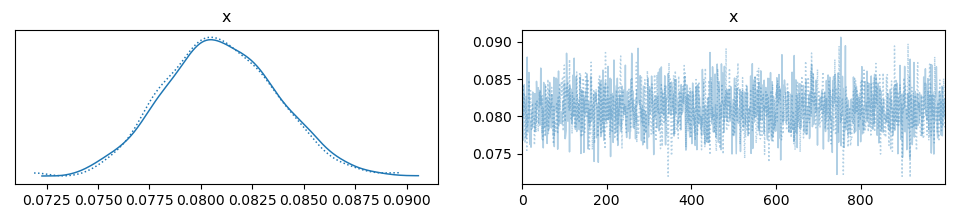

In [70]:
az.plot_trace(cdata)

# Headless network

In [12]:
from gabenet.nets import MultinomialDirichletBelieve
from gabenet.layers import Sequential
from gabenet.multinomial import MultinomialLayer, DirichletLayer

theta_2 = jnp.ones((m_samples, 2)) / 2

@hk.transform_with_state
def forward_mult_dir():
    layer1 = MultinomialLayer(10, n_features)
    layer2 = DirichletLayer(2, 10)
    return layer1.forward(layer2.forward(theta_2))


@hk.transform_with_state
def step_mult_dir():
    layer1 = MultinomialLayer(10, n_features)
    layer2 = DirichletLayer(2, 10)
    layer2.upward(*layer1.upward(X_train))
    layer1.downward(*layer2.downward(theta_2))


In [13]:
n_chains = 4
key_per_chain = random.split(next(key_seq), num=n_chains)
param_init, state_init = jax.vmap(forward_mult_dir.init)(key_per_chain)

In [14]:
step = jax.jit(step_mult_dir.apply)

In [15]:
def plots_to_tensorboard2(states, writer, i):
    with writer.as_default():
        c = states['dirichlet_layer']['c']
        f_c = plot_convergence_1d(c)
        tf.summary.image('c', plot_to_tensor(f_c), step=i)
        writer.flush()

In [16]:
state_checkpoints = []

for i in range(10):

    states = sample_markov_chain(
        next(key_seq), 
        n_samples=60, 
        kernel_fn=step, 
        initial_params=param_init, 
        initial_state=state_init,
        n_burnin_steps=0, 
        n_leap_size=20,
    )

    states['multinomial_layer']['phi'].block_until_ready()
    print(f'Save checkpoint {i+1}')
    state_init = jax.tree_util.tree_map(lambda x: x[:, -1,...], states)
    state_checkpoints.append(states)

    # Make a plot.
    all_states = jax.tree_util.tree_map(lambda *args: jnp.concatenate(args, axis=1), *state_checkpoints)
    plots_to_tensorboard2(all_states, writer, i=i+1)

Save checkpoint 1
Save checkpoint 2
Save checkpoint 3
Save checkpoint 4
Save checkpoint 5
Save checkpoint 6
Save checkpoint 7


In [46]:
states['multinomial_layer']

{'phi': Array([[[[4.73892651e-05, 1.06565142e-03, 1.45241329e-02, ...,
           1.57029144e-02, 6.03697356e-03, 1.37296051e-03],
          [3.75564332e-06, 1.17964041e-03, 6.34105317e-03, ...,
           8.59717652e-03, 5.67553565e-03, 1.98025885e-03],
          [5.03352112e-06, 9.94764268e-04, 1.27156721e-02, ...,
           2.94843242e-02, 7.71158468e-03, 2.78292864e-04],
          ...,
          [4.24039536e-06, 4.96410357e-04, 1.38525488e-02, ...,
           1.84067618e-02, 6.05496019e-03, 6.26597845e-04],
          [3.13184537e-05, 9.42484592e-04, 2.33125631e-02, ...,
           1.82968546e-02, 6.93087419e-03, 1.69196201e-03],
          [6.03669014e-06, 8.76994513e-04, 1.52449831e-02, ...,
           9.84577835e-03, 1.12052187e-02, 1.61675294e-03]],
 
         [[6.53164680e-05, 1.24321191e-03, 1.94672216e-02, ...,
           1.39215477e-02, 6.80522993e-03, 1.76517339e-03],
          [7.34774221e-05, 8.50568700e-04, 1.00519080e-02, ...,
           1.34829571e-02, 5.91890980e-03, 

In [ ]:
states = sample_markov_chain(
    next(key_seq), 
    n_samples=100, 
    kernel_fn=step_mult_dir, 
    initial_params=param_init, 
    initial_state=state_init,
    n_burnin_steps=100, 
    # n_leap_size=0,
)
states['multinomial_dirichlet_believe/~/dirichlet_layer']['c'].block_until_ready()